In [235]:
# Python
# Third
# Property
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
from ipywidgets import IntProgress, FloatProgress
from IPython.display import display

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 150)


### TODO
- Type hint
- Field
- Optional
- Document functions
- Pytest/Unit Tests (Udacity content)
- log (Udacity content)

In [236]:
# Parameters
LST_B3_STOCKS = ["RRRP3", "ALOS3", "ALPA4", "ABEV3", "ASAI3", "AZUL4", "AZZA3", "B3SA3", "BBSE3", "BBDC3", "BBDC4", "BRAP4", "BBAS3", "BRKM5", "BRFS3", "BPAC11", "CRFB3", "CCRO3", "CMIG4", "COGN3", "CPLE6", "CSAN3", "CPFE3", "CMIN3", "CVCB3", "CYRE3", "DXCO3", "ELET3", "ELET6", "EMBR3", "ENGI11", "ENEV3", "EGIE3", "EQTL3", "EZTC3", "FLRY3", "GGBR4", "GOAU4", "NTCO3", "HAPV3", "HYPE3", "IGTI11", "IRBR3", "ITSA4", "ITUB4", "JBSS3", "KLBN11", "RENT3", "LREN3", "LWSA3", "MGLU3", "MRFG3", "BEEF3", "MRVE3", "MULT3", "PCAR3", "PETR3", "PETR4", "RECV3", "PRIO3", "PETZ3", "RADL3", "RAIZ4", "RDOR3", "RAIL3", "SBSP3", "SANB11", "SMTO3", "CSNA3", "SLCE3", "SUZB3", "TAEE11", "VIVT3", "TIMS3", "TOTS3", "TRPL4", "UGPA3", "USIM5", "VALE3", "VAMO3", "VBBR3", "VIVA3", "WEGE3", "YDUQ3"]
PATH_LS_DATA = 'ls_data/'

In [316]:
def get_yahoo_asset_data(lst_stock_tickers, start_date, end_date):
    lst_assets=[]
    for ticker in lst_stock_tickers:
        df_stock = yf.download(ticker+'.SA', start = start_date, end = end_date, progress=False)
        
        if len(df_stock) != 0:
            df_stock = df_stock.loc[:,["Adj Close"]]
            df_stock.loc[:, "ticker"] = ticker
            lst_assets.append(df_stock)

    return pd.concat(lst_assets)

def pivote_asset_data(df):
    # Reseting index to pivoting
    df.reset_index(inplace = True)
    
    # Pivoting Data
    df = df.pivot(index = "Date", columns = "ticker", values = "Adj Close")
    
    # Renaming index
    df.index.names = ['date']

    # Fill NA
    df = df.fillna(method='ffill')

    return df

def create_long_short_dataset(lst_stock_tickers, start_date, end_date, source = 'yahoo'):
    if source == 'yahoo':
        df = get_yahoo_asset_data(lst_stock_tickers = LST_B3_STOCKS, start_date = "2018-01-01", end_date = end_date)
        df = pivote_asset_data(df)
        df.to_csv(PATH_LS_DATA+'yahoo_long_short_data.csv')
    else:
        pass

def load_long_short_dataset(max_date = None, source = 'yahoo'):
    if source == 'yahoo':
        if max_date == None:
            return pd.read_csv(PATH_LS_DATA+'yahoo_long_short_data.csv', index_col = 'date').reset_index()
        else:
            return pd.read_csv(PATH_LS_DATA+'yahoo_long_short_data.csv', index_col = 'date').loc[:max_date].reset_index()
    else:
        pass
    
def getPairs(df):
    assets = list(df.columns)
    assets.remove('date')
    
    lst_pairs = []
    for first in assets:
        for second in assets:
            if first != second:
                lst_pairs.append(first+'/'+second)
                
    return lst_pairs

def blog_half_life(ts):  
    """ 
    Calculates the half life of a mean reversion
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    ts = ts[::-1]

    # delta = p(t) - p(t-1)
    delta_ts = np.diff(ts)
    
    # calculate the vector of lagged values. lag = 1
    lag_ts = np.vstack([ts[:-1], np.ones(len(ts[:-1]))]).T
   
    # calculate the slope of the deltas vs the lagged values 
    # Ref: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
    lambda_, const = np.linalg.lstsq(lag_ts, delta_ts, rcond=None)[0]

    # compute and return half life
    # negative sign to turn half life to a positive value
    return - np.log(2) / lambda_

def gpt_half_life(residuals):
    residuals = residuals[::-1]

    # Ensure residuals are in numpy array format
    residuals = np.array(residuals)
    
    # Fit an AR(1) model to the residuals
    model = AutoReg(residuals, lags=1).fit()
    
    # Get the autoregressive coefficient (phi)
    phi = model.params[1]
    
    # Calculate the half-life
    half_life = -np.log(2) / np.log(abs(phi))
    
    return half_life

def getPairsResiduals(lst_pairs, df_stocks, date_col, periods):
    df_residuals = pd.DataFrame()
    df_residuals[date_col] = df_stocks[date_col].sort_values(ascending = False)[:periods]
    
    pairs_column = []
    p_values = []
    adf_column = []
    beta_column = []
    desv_column = []
    halflife_column = []
    
    progress_bar = IntProgress(min=0, max=len(lst_pairs))
    display(progress_bar)
    for i, pair in enumerate(lst_pairs):
        progress_bar.value = i+1
        
        asset1 = pair.split('/')[0]
        asset2 = pair.split('/')[1]
        
        df_res = df_stocks[[date_col, asset1, asset2]].sort_values(by=date_col, ascending = False)[:periods]
        
        X = df_res.iloc[:, 1].values.reshape(-1, 1)
        Y = df_res.iloc[:, 2].values.reshape(-1, 1)
        
        # Ignoring pairs with NaN values
        if df_res.iloc[:, 1].isna().sum() > 0 or df_res.iloc[:, 2].isna().sum() > 0:
            continue

        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        
        Y_pred = linear_regressor.predict(X)
        df_res['residual'] =  Y - Y_pred
        
        df_residuals[pair] = df_res['residual']
        
        mean = df_res['residual'].mean()
        std = df_res['residual'].std()
        
        adf = adfuller(df_res['residual'])
        adf_column.append(adf[0])
        p_values.append(np.round((1-adf[1])*100,2))
        pairs_column.append(pair) 
        beta_column.append(np.round(linear_regressor.coef_[0][0],2))
        desv_column.append(np.round(((df_res['residual'].iloc[0] - mean)/std),2))
        #halflife_column.append(np.round((-np.log(2)/linear_regressor.coef_[0][0]),0))
        hl_gpt = gpt_half_life(df_res['residual'])
        hl_blog = blog_half_life(df_res['residual'])
        halflife_column.append(np.round(np.mean([hl_blog,hl_gpt]),0))
        
    
    dict_stats = {'pair':pairs_column,
                  'adf':adf_column,
                  'beta':beta_column,
                  'desv':desv_column,
                  'halflife':halflife_column,
                  'p_value':p_values
                 }
    
    df_stats = pd.DataFrame(dict_stats)
    
    return df_residuals, df_stats

def double_cointegration(df, check = False):
    if check == True:
        lst_pairs = list(df.pair)
        double_cointegration_pairs = []
        for pair in lst_pairs:
            inverted_pair = pair.split('/')[1]+'/'+pair.split('/')[0]
            if inverted_pair in lst_pairs:
                double_cointegration_pairs.append(pair)
        return df[df["pair"].isin(double_cointegration_pairs)]
    else:
        return df

def normalize_column(df, column_name):
    # Calculate mean and standard deviation of the column
    mean = df[column_name].mean()
    std = df[column_name].std()
    
    # Normalize the column
    df[column_name] = (df[column_name] - mean) / std
    
    return df[column_name]

In [238]:
create_long_short_dataset(LST_B3_STOCKS, "2018-01-01", None, source = 'yahoo')

In [318]:
df_stocks = load_long_short_dataset(max_date = "2024-01-01")
#df_stocks = load_long_short_dataset()
lst_pairs = getPairs(df_stocks)

## L&S Screaning

Gerênciamento de risco
- 160 períodos: 1/3 do Capital para cada trade.
- 200 períodos: 1/2 do Capital para cada trade.
- 252 períodos: 100% do Capital para cada trade.


Teste ADF
- 1% -4,32%
- 5% -3,78%
- 10% -3,50%

Interpretação do Beta
- Para cada 1 real do ativo 1, operar beta*reais do ativo 2

In [319]:
prds = np.arange(20, 201, 5)
prds = [200]
lst_df_pairs_res = []
lst_df_pairs_stats = []
for periodo in prds:
    print(f"Calculando estatísticas para período de {periodo} dias...")
    df_pairs_res, df_pairs_stats = getPairsResiduals(lst_pairs, df_stocks, date_col = 'date', periods = periodo)
    lst_df_pairs_res.append(df_pairs_res)
    df_pairs_stats["periodo"] = periodo
    lst_df_pairs_stats.append(df_pairs_stats)

Calculando estatísticas para período de 200 dias...


IntProgress(value=0, max=6972)

In [313]:
prd_index = 0
df_pairs_res = lst_df_pairs_res[prd_index]
df_pairs_stats = lst_df_pairs_stats[prd_index]

df_screaning = df_pairs_stats[
    (df_pairs_stats['adf'] <= -3.78) & 
    (df_pairs_stats['desv'] >= 1.80) & 
    (df_pairs_stats['desv'] < 2.5) & 
    (df_pairs_stats['beta'] >= 0.5) & 
    (df_pairs_stats['beta'] < 2) & 
    (df_pairs_stats['halflife'] <= 10)]

df_screaning["beta_parity"] = abs(df_screaning["beta"]-1)
df_screaning = df_screaning.sort_values(by='beta_parity').drop(columns=['beta_parity'])

df_screaning = double_cointegration(df_screaning, check = True)

df_screaning.reset_index(drop=True)

,pair,adf,beta,desv,halflife,p_value,periodo
0,CSAN3/ENGI11,-5.250055,1.14,2.37,5.0,100.00,200
1,BBDC4/BBDC3,-3.998732,0.86,2.11,5.0,99.86,200
2,BBDC3/BBDC4,-3.990658,1.15,1.91,5.0,99.85,200
3,ENGI11/CSAN3,-4.987241,0.68,2.45,6.0,100.00,200
4,HYPE3/ALOS3,-4.426214,0.51,2.21,5.0,99.97,200
5,ALOS3/HYPE3,-4.476403,1.51,1.96,4.0,99.98,200


0
CSAN3/ENGI11
Beta:  1.14
Desv:  2.37
Halflife:  5.0


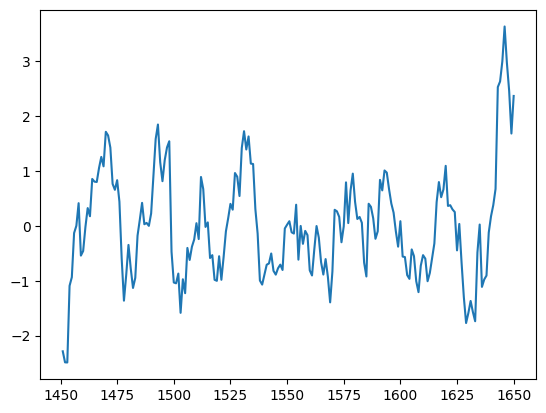

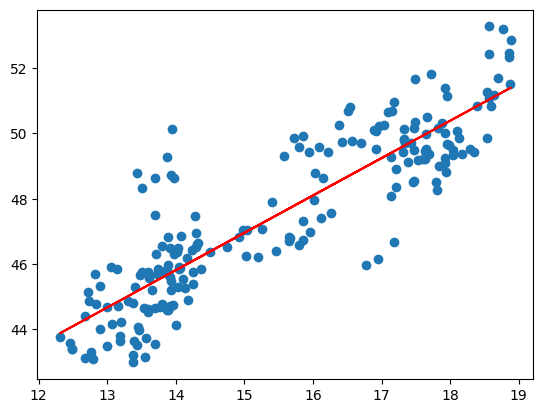

1
BBDC4/BBDC3
Beta:  0.86
Desv:  2.11
Halflife:  5.0


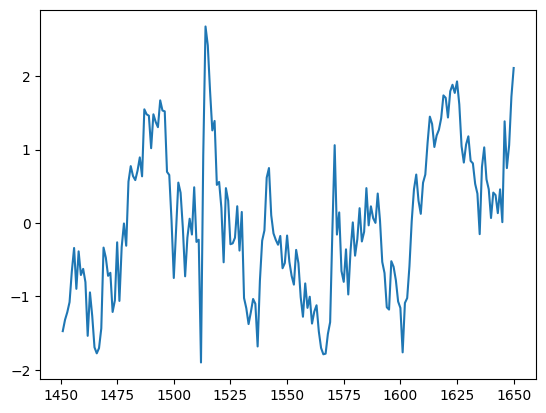

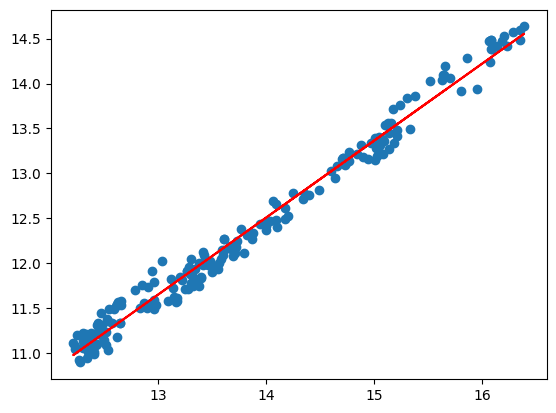

2
BBDC3/BBDC4
Beta:  1.15
Desv:  1.91
Halflife:  5.0


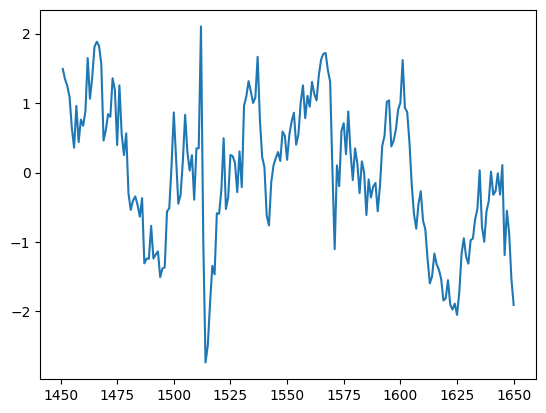

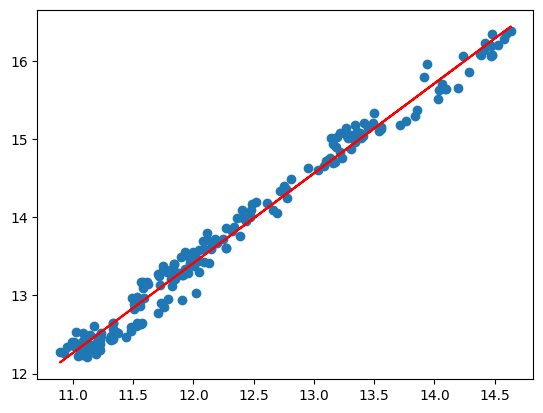

3
ENGI11/CSAN3
Beta:  0.68
Desv:  2.45
Halflife:  6.0


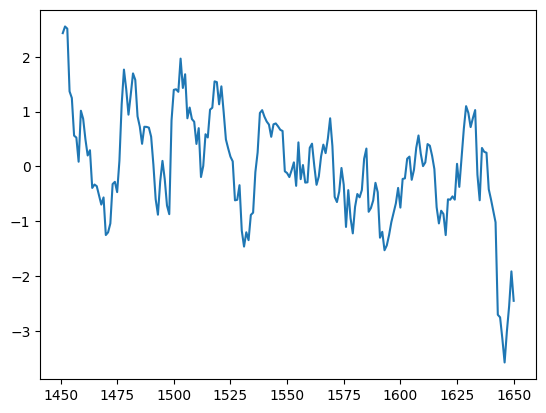

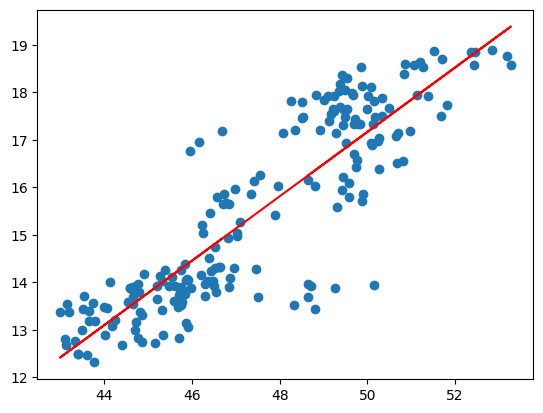

4
HYPE3/ALOS3
Beta:  0.51
Desv:  2.21
Halflife:  5.0


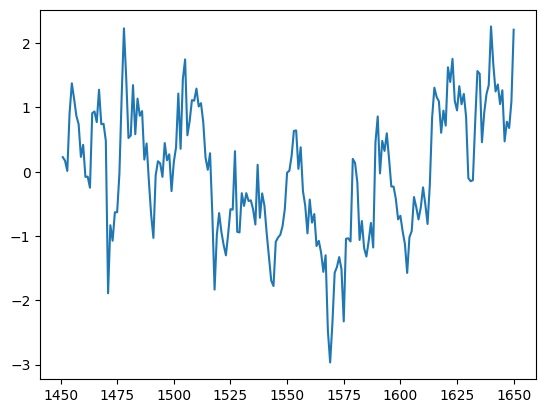

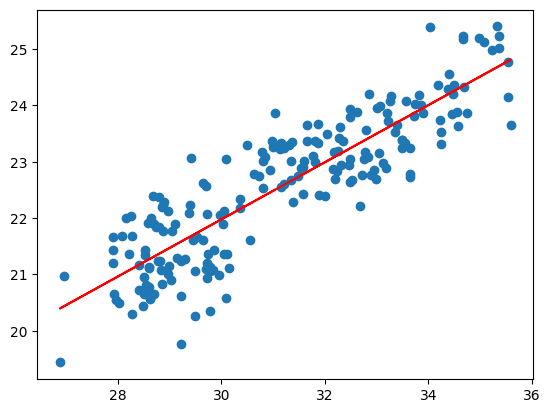

5
ALOS3/HYPE3
Beta:  1.51
Desv:  1.96
Halflife:  4.0


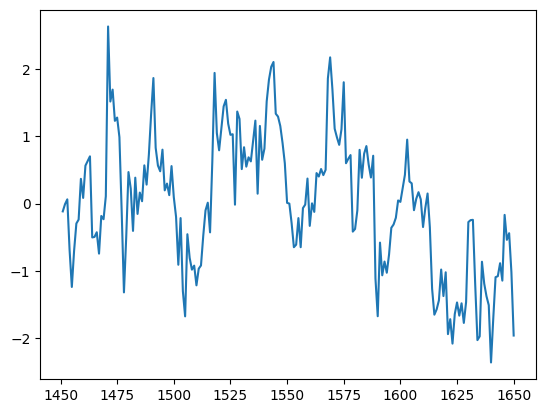

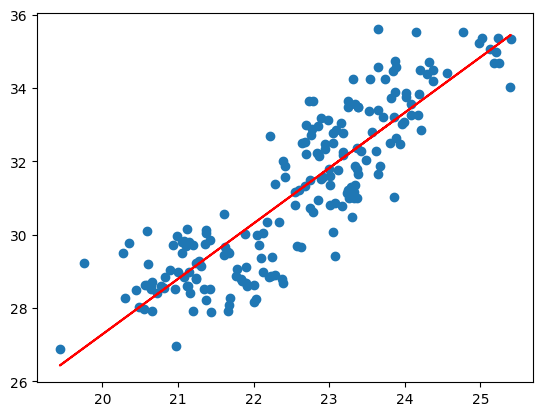

In [310]:
for n_pair in range(len(df_screaning)):
    print(n_pair)
    print(df_screaning.iloc[n_pair,0])
    print("Beta: ", df_screaning.iloc[n_pair,2])
    print("Desv: ", df_screaning.iloc[n_pair,3])
    print("Halflife: ", df_screaning.iloc[n_pair,4])

    # Residual
    pair1 = df_screaning.iloc[n_pair,0].split('/')[0]
    pair2 = df_screaning.iloc[n_pair,0].split('/')[1]
    df_res_aux = normalize_column(df_pairs_res, pair1+'/'+pair2)

    plt.plot(df_res_aux)
    plt.show()

    # Regression
    df_aux = df_stocks[[pair1, pair2]]
    df_aux = df_aux.iloc[-prds[prd_index]:, :]
    X = df_aux.iloc[:, 0].values.reshape(-1, 1)
    Y = df_aux.iloc[:, 1].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    
    Y_pred = linear_regressor.predict(X)

    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='red')
    plt.show()

In [329]:
from datetime import datetime, timedelta

def generate_workdays_list(start_date, end_date):
    # Convert the input strings to datetime objects
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Generate the list of workdays
    workdays_list = []
    while start <= end:
        if start.weekday() < 5:  # Monday = 0, Sunday = 6
            workdays_list.append(start.strftime('%Y-%m-%d'))
        start += timedelta(days=1)
    
    return workdays_list

lst_dates = generate_workdays_list("2024-01-01", "2024-08-23")

lst_holydays = ["2024-01-01","2024-02-12","2024-02-13","2024-03-29","2024-05-01","2024-05-30","2024-11-15","2024-12-24","2024-12-25","2024-12-31"]

lst_dates = [item for item in lst_dates if item not in lst_holydays]

lst_df_pairs_stats = []

for trading_date in lst_dates:
    print(trading_date)
    df_stocks = load_long_short_dataset(max_date = trading_date)
    lst_pairs = getPairs(df_stocks)
    #prds = [60, 120, 160, 180, 200, 252]
    prds = [200]
    
    for periodo in prds:
        _, df_pairs_stats = getPairsResiduals(lst_pairs, df_stocks, date_col = 'date', periods = periodo)
        df_pairs_stats["periodo"] = periodo
        df_pairs_stats["trading_date"] = trading_date
        df_pairs_stats = double_cointegration(df_pairs_stats, check = True)
        df_screaning["beta_parity"] = abs(df_screaning["beta"]-1)
        df_screaning = df_screaning.sort_values(by='beta_parity').drop(columns=['beta_parity'])

        lst_df_pairs_stats.append(df_pairs_stats)
    
df_backtest = pd.concat(lst_df_pairs_stats, ignore_index=True)

df_backtest.to_csv(PATH_LS_DATA+'yahoo_long_short_backtest.csv')

df_screaning = df_backtest[
    (df_backtest['adf'] <= -3.78) & 
    (df_backtest['desv'] >= 1.80) & 
    (df_backtest['desv'] < 2.5) & 
    (df_backtest['beta'] >= 0.5) & 
    (df_backtest['beta'] < 2) & 
    (df_backtest['halflife'] <= 10)]

df_backtest.reset_index(drop=True)

2024-01-02


IntProgress(value=0, max=6972)

2024-01-03


IntProgress(value=0, max=6972)

2024-01-04


IntProgress(value=0, max=6972)

2024-01-05


IntProgress(value=0, max=6972)